In [1]:
!pip install opencv-python

In [2]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models

from src.resnet_yolo import resnet50
from yolo_loss import YoloLoss
from src.dataset import VocDetectorDataset
from src.eval_voc import evaluate
from src.predict import predict_image
from src.config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv

import matplotlib.pyplot as plt
import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Initialization

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1 million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effectively.

In [ ]:
load_network_path = 'checkpoints/best_detector.pth' 
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

In [6]:
learning_rate = 0.001
num_epochs = 50
batch_size = 24

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection datasets since the bounding box annotations must be kept consistent throughout the transformations.

Since the output of the detector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [7]:
file_root_train = 'data/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'data/voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [8]:
file_root_test = 'data/VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = 'data/voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


In [9]:
data = train_dataset[0]

## Set up training tools

In [10]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Train detector

In [11]:
best_test_loss = np.inf
learning_rate = 1e-3
for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = collections.defaultdict(int)
    
    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()
        
        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()
        
        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)
    
    # evaluate the network on the test data
    if (epoch + 1) % 2 == 0:
        test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)
        print(epoch, test_aps)
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, data in enumerate(test_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data
            
            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            test_loss += loss_dict['total_loss'].item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'checkpoints/best_detector.pth')
    
    if (epoch+1) in [5, 10, 20, 30, 40]:
        torch.save(net.state_dict(),'checkpoints/detector_epoch_%d.pth' % (epoch+1))

    torch.save(net.state_dict(),'checkpoints/detector.pth')



Starting epoch 1 / 50
Learning Rate for this epoch: 0.001
Epoch [1/50], Iter [50/209], Loss: total=20.282, reg=0.758, containing_obj=0.302, no_obj=12.558, cls=6.664
Epoch [1/50], Iter [100/209], Loss: total=12.459, reg=0.597, containing_obj=0.403, no_obj=6.510, cls=4.949
Epoch [1/50], Iter [150/209], Loss: total=9.522, reg=0.501, containing_obj=0.468, no_obj=4.447, cls=4.107
Epoch [1/50], Iter [200/209], Loss: total=7.916, reg=0.448, containing_obj=0.501, no_obj=3.398, cls=3.569
Updating best test loss: 2.81143


Starting epoch 2 / 50
Learning Rate for this epoch: 0.001
Epoch [2/50], Iter [50/209], Loss: total=2.786, reg=0.256, containing_obj=0.647, no_obj=0.205, cls=1.678
Epoch [2/50], Iter [100/209], Loss: total=2.726, reg=0.250, containing_obj=0.656, no_obj=0.191, cls=1.629
Epoch [2/50], Iter [150/209], Loss: total=2.674, reg=0.242, containing_obj=0.674, no_obj=0.180, cls=1.578
Epoch [2/50], Iter [200/209], Loss: total=2.626, reg=0.238, containing_obj=0.690, no_obj=0.171, cls=1.52

100%|██████████████████████████████████████████████████████████████████████████| 4950/4950 [04:48<00:00, 17.17it/s]


---class aeroplane ap 0.0---
---class bicycle ap 0.16180225066579498---
---class bird ap 0.050254781324748504---
---class boat ap 0.005640050697084918---
---class bottle ap 0.008016038635536505---
---class bus ap 0.012718736662398634---
---class car ap 0.10883903387478934---
---class cat ap 0.015426612493651602---
---class chair ap 0.07147340774359068---
---class cow ap 0.01677266315825786---
---class diningtable ap 0.03730243061548283---
---class dog ap 0.009109499907045918---
---class horse ap 0.27726250536766983---
---class motorbike ap 0.03393650793650793---
---class person ap 0.19798578996096022---
---class pottedplant ap 0.020896391861393644---
---class sheep ap 0.026914110454892993---
---class sofa ap 0.09791313451718792---
---class train ap 0.0--- (no predictions for this class)
---class tvmonitor ap 0.0214736553908757---
---map 0.058686880063393496---
4 [0.0, 0.16180225066579498, 0.050254781324748504, 0.005640050697084918, 0.008016038635536505, 0.012718736662398634, 0.10883903

100%|██████████████████████████████████████████████████████████████████████████| 4950/4950 [04:48<00:00, 17.17it/s]


---class aeroplane ap 0.02034551176364576---
---class bicycle ap 0.2537945477997502---
---class bird ap 0.28615524238100853---
---class boat ap 0.030357937526723017---
---class bottle ap 0.0631265097720026---
---class bus ap 0.13176574503957636---
---class car ap 0.27833745812601074---
---class cat ap 0.4610159026823607---
---class chair ap 0.19049415617023951---
---class cow ap 0.25777506527948113---
---class diningtable ap 0.1235939495379418---
---class dog ap 0.45396159693159005---
---class horse ap 0.5053660947865947---
---class motorbike ap 0.3698853549069565---
---class person ap 0.37568783374726605---
---class pottedplant ap 0.10161283548028699---
---class sheep ap 0.1486620344400786---
---class sofa ap 0.3143377689233451---
---class train ap 0.06266422519888495---
---class tvmonitor ap 0.3413305919028129---
---map 0.23851351811982782---
9 [0.02034551176364576, 0.2537945477997502, 0.28615524238100853, 0.030357937526723017, 0.0631265097720026, 0.13176574503957636, 0.2783374581260

100%|██████████████████████████████████████████████████████████████████████████| 4950/4950 [04:51<00:00, 16.99it/s]


---class aeroplane ap 0.216875352916388---
---class bicycle ap 0.3805439520385306---
---class bird ap 0.29678468290809723---
---class boat ap 0.07215253193225421---
---class bottle ap 0.10772409907055841---
---class bus ap 0.2712860760140248---
---class car ap 0.4297386545524269---
---class cat ap 0.48755496380264673---
---class chair ap 0.23776192698728907---
---class cow ap 0.31846693237577894---
---class diningtable ap 0.2708074179350716---
---class dog ap 0.5290188336610566---
---class horse ap 0.5372246140845858---
---class motorbike ap 0.40454593382644294---
---class person ap 0.4396565086355186---
---class pottedplant ap 0.1023262797799851---
---class sheep ap 0.2509048449120873---
---class sofa ap 0.4003952932562719---
---class train ap 0.2704075653889449---
---class tvmonitor ap 0.33577047370891816---
---map 0.3179973468893439---
14 [0.216875352916388, 0.3805439520385306, 0.29678468290809723, 0.07215253193225421, 0.10772409907055841, 0.2712860760140248, 0.4297386545524269, 0.4

100%|██████████████████████████████████████████████████████████████████████████| 4950/4950 [04:49<00:00, 17.12it/s]


---class aeroplane ap 0.3062029957592992---
---class bicycle ap 0.39716456528748023---
---class bird ap 0.37797558505676165---
---class boat ap 0.11283306535865682---
---class bottle ap 0.1308951932896614---
---class bus ap 0.2687620898846682---
---class car ap 0.477317671965637---
---class cat ap 0.6007814817047246---
---class chair ap 0.27340198028649---
---class cow ap 0.385893303663876---
---class diningtable ap 0.23042511111791833---
---class dog ap 0.516259952336187---
---class horse ap 0.5769494811203189---
---class motorbike ap 0.450215729544065---
---class person ap 0.46571790056167994---
---class pottedplant ap 0.11625893081245825---
---class sheep ap 0.254914706733981---
---class sofa ap 0.32580166521457277---
---class train ap 0.3689891366080237---
---class tvmonitor ap 0.39946622367988005---
---map 0.351811338499317---
19 [0.3062029957592992, 0.39716456528748023, 0.37797558505676165, 0.11283306535865682, 0.1308951932896614, 0.2687620898846682, 0.477317671965637, 0.60078148

100%|██████████████████████████████████████████████████████████████████████████| 4950/4950 [04:50<00:00, 17.03it/s]


---class aeroplane ap 0.3423936349683237---
---class bicycle ap 0.46661852375538776---
---class bird ap 0.3892442909087511---
---class boat ap 0.12549682126394052---
---class bottle ap 0.14377078387140818---
---class bus ap 0.39917584114032173---
---class car ap 0.5267707765871412---
---class cat ap 0.6304396503986563---
---class chair ap 0.2705436141270141---
---class cow ap 0.3928064563060163---
---class diningtable ap 0.24561833414441972---
---class dog ap 0.5905668104353661---
---class horse ap 0.6302119059996056---
---class motorbike ap 0.5083191997204166---
---class person ap 0.48262776200624297---
---class pottedplant ap 0.1134428845297849---
---class sheep ap 0.2806737988029109---
---class sofa ap 0.4242059772412718---
---class train ap 0.4542725760850599---
---class tvmonitor ap 0.40001253868297365---
---map 0.39086060904875064---
24 [0.3423936349683237, 0.46661852375538776, 0.3892442909087511, 0.12549682126394052, 0.14377078387140818, 0.39917584114032173, 0.5267707765871412, 

100%|██████████████████████████████████████████████████████████████████████████| 4950/4950 [04:54<00:00, 16.83it/s]


---class aeroplane ap 0.41081837479607797---
---class bicycle ap 0.4952555308883966---
---class bird ap 0.4281897964855462---
---class boat ap 0.20472913793003344---
---class bottle ap 0.13838697274549297---
---class bus ap 0.5047330910591759---
---class car ap 0.5439554854245512---
---class cat ap 0.6831445362405061---
---class chair ap 0.27662787708820874---
---class cow ap 0.43327686676887367---
---class diningtable ap 0.2756582090413899---
---class dog ap 0.6268932789174302---
---class horse ap 0.6250985365007871---
---class motorbike ap 0.4415468437746345---
---class person ap 0.4809767904621072---
---class pottedplant ap 0.13256070943059306---
---class sheep ap 0.3927425636711426---
---class sofa ap 0.4176253696555413---
---class train ap 0.4607593972108821---
---class tvmonitor ap 0.42781575784482406---
---map 0.4200397562968098---
29 [0.41081837479607797, 0.4952555308883966, 0.4281897964855462, 0.20472913793003344, 0.13838697274549297, 0.5047330910591759, 0.5439554854245512, 0.

100%|██████████████████████████████████████████████████████████████████████████| 4950/4950 [04:52<00:00, 16.94it/s]


---class aeroplane ap 0.40689498434996213---
---class bicycle ap 0.5058468618202662---
---class bird ap 0.39348829957770354---
---class boat ap 0.19673749499045934---
---class bottle ap 0.14968494493464318---
---class bus ap 0.5329337406131149---
---class car ap 0.5585720088965459---
---class cat ap 0.665062291592666---
---class chair ap 0.2895871210013118---
---class cow ap 0.46112237103977427---
---class diningtable ap 0.3032119583259736---
---class dog ap 0.6146089554193378---
---class horse ap 0.6190622700721521---
---class motorbike ap 0.4977766918303205---
---class person ap 0.47799714532382365---
---class pottedplant ap 0.14708503965889946---
---class sheep ap 0.36779702466516995---
---class sofa ap 0.416875077885918---
---class train ap 0.522114990541861---
---class tvmonitor ap 0.408383563361045---
---map 0.4267421417950474---
34 [0.40689498434996213, 0.5058468618202662, 0.39348829957770354, 0.19673749499045934, 0.14968494493464318, 0.5329337406131149, 0.5585720088965459, 0.66

100%|██████████████████████████████████████████████████████████████████████████| 4950/4950 [04:51<00:00, 16.99it/s]


---class aeroplane ap 0.39392219812925344---
---class bicycle ap 0.5304450455435932---
---class bird ap 0.4240434990620282---
---class boat ap 0.2069551929410681---
---class bottle ap 0.16418624635233597---
---class bus ap 0.5370936198645698---
---class car ap 0.5798126911149538---
---class cat ap 0.6762609385078249---
---class chair ap 0.2787603057040069---
---class cow ap 0.45807662508969693---
---class diningtable ap 0.2727564320761733---
---class dog ap 0.6566636668092489---
---class horse ap 0.6308957299729849---
---class motorbike ap 0.509241848567119---
---class person ap 0.5115735711406362---
---class pottedplant ap 0.15641108616519295---
---class sheep ap 0.40323737138313454---
---class sofa ap 0.3912679711541377---
---class train ap 0.5359649300269763---
---class tvmonitor ap 0.42513424435246494---
---map 0.43713516069787---
39 [0.39392219812925344, 0.5304450455435932, 0.4240434990620282, 0.2069551929410681, 0.16418624635233597, 0.5370936198645698, 0.5798126911149538, 0.67626

100%|██████████████████████████████████████████████████████████████████████████| 4950/4950 [04:56<00:00, 16.68it/s]


---class aeroplane ap 0.4010680141968908---
---class bicycle ap 0.5352807114670718---
---class bird ap 0.4128313753279085---
---class boat ap 0.21268792568372488---
---class bottle ap 0.15397171340513666---
---class bus ap 0.5094258447237363---
---class car ap 0.5682273020262467---
---class cat ap 0.6640722954733677---
---class chair ap 0.29108190707173276---
---class cow ap 0.4840763519680744---
---class diningtable ap 0.2731559322688139---
---class dog ap 0.6422910307613162---
---class horse ap 0.6546952670916167---
---class motorbike ap 0.49561648800034097---
---class person ap 0.5027616680940983---
---class pottedplant ap 0.13691052119668015---
---class sheep ap 0.4126395215698623---
---class sofa ap 0.3908125573200773---
---class train ap 0.5344035490778188---
---class tvmonitor ap 0.4249300701214508---
---map 0.4350470023422983---
44 [0.4010680141968908, 0.5352807114670718, 0.4128313753279085, 0.21268792568372488, 0.15397171340513666, 0.5094258447237363, 0.5682273020262467, 0.664

100%|██████████████████████████████████████████████████████████████████████████| 4950/4950 [04:53<00:00, 16.86it/s]


---class aeroplane ap 0.41898268204134836---
---class bicycle ap 0.5312058757554363---
---class bird ap 0.4044105459620767---
---class boat ap 0.21148832292734626---
---class bottle ap 0.15312456842189887---
---class bus ap 0.5428663066715351---
---class car ap 0.5850070261296993---
---class cat ap 0.6695354745000114---
---class chair ap 0.28071355643665696---
---class cow ap 0.48852292523394747---
---class diningtable ap 0.28166902629179985---
---class dog ap 0.6544899852729749---
---class horse ap 0.6353182414784873---
---class motorbike ap 0.5208118627331441---
---class person ap 0.5045412672131862---
---class pottedplant ap 0.16088847699672715---
---class sheep ap 0.4169567567609397---
---class sofa ap 0.40122079260189575---
---class train ap 0.5650421008274267---
---class tvmonitor ap 0.45362020920366775---
---map 0.4440208001730103---
49 [0.41898268204134836, 0.5312058757554363, 0.4044105459620767, 0.21148832292734626, 0.15312456842189887, 0.5428663066715351, 0.5850070261296993, 

# View example predictions

predicting...


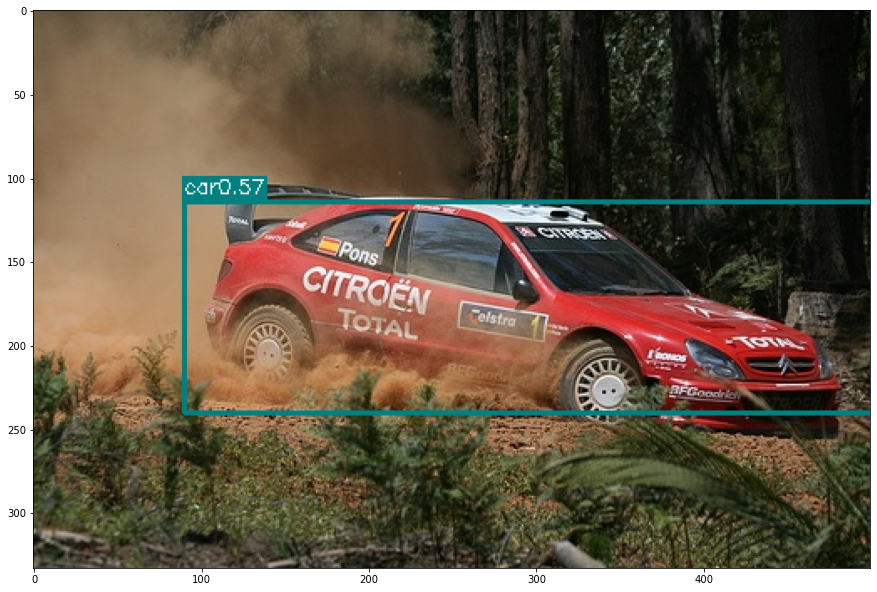

In [12]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [13]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)

---Evaluate model on test samples---


100%|██████████████████████████████████████████████████████████████████████████| 4950/4950 [04:52<00:00, 16.93it/s]


---class aeroplane ap 0.41898268204134836---
---class bicycle ap 0.5312058757554363---
---class bird ap 0.4044105459620767---
---class boat ap 0.21148832292734626---
---class bottle ap 0.15312456842189887---
---class bus ap 0.5428663066715351---
---class car ap 0.5850070261296993---
---class cat ap 0.6695354745000114---
---class chair ap 0.28071355643665696---
---class cow ap 0.48852292523394747---
---class diningtable ap 0.28166902629179985---
---class dog ap 0.6544899852729749---
---class horse ap 0.6353182414784873---
---class motorbike ap 0.5208118627331441---
---class person ap 0.5045412672131862---
---class pottedplant ap 0.16088847699672715---
---class sheep ap 0.4169567567609397---
---class sofa ap 0.40122079260189575---
---class train ap 0.5650421008274267---
---class tvmonitor ap 0.45362020920366775---
---map 0.4440208001730103---
